In [39]:
from importlib import reload
from bowzer import model, data_processing, constants
reload(model)
reload(data_processing)
reload(constants)

<module 'bowzer.constants' from '/Volumes/KCQDrive/projects/bowzer_drive/bowzer/constants.py'>

In [40]:
from bowzer.constants import (
    RESIZE_N, 
    DIR
)

128

In [41]:

from datetime import datetime
import torch
from torch.nn import CrossEntropyLoss
from torchmetrics import Precision, Recall
device = ("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using {device} device")

Using cpu device


In [43]:
epochs = 3

data_module = data_processing.Dataset(RESIZE_N)
dataloader_train, dataloader_test = data_module.process()
num_classes = len(dataloader_train.dataset.classes)
#net = model.net(data_module.num_classes,  data_module.resize_n).to(device)
net = model.BowzerClassifier(num_classes).to(device)
loss_fn = CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr = 0.001)

def train_epoch(dataloader_train, model, loss_fn, optimizer) -> float:
    running_loss = 0.0
    model.train()
    for batch, (images, labels) in enumerate(dataloader_train):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        preds = model(images)
        loss = loss_fn(preds, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if batch % 100 == 0:
            print(f"loss: {loss.item():>7f}  [{(batch + 1) * len(images):>5d}/{len(dataloader_train.dataset):>5d}]")
    avg_loss = running_loss / (batch + 1)
    return avg_loss

#def train_eval(epochs, dataloader_train, dataloader_test, model, loss_fn, optimizer):
for epoch in range(epochs):
    print(f"EPOCH {epoch + 1}:")
    avg_loss = train_epoch(dataloader_train, net, loss_fn, optimizer)
    
print("Evaluation:")
metric_precision = Precision(task='multiclass', num_classes=num_classes, average='macro')
metric_recall = Recall(task='multiclass', num_classes=num_classes, average='macro')
net.eval()
total, correct = 0, 0
for images, labels in dataloader_test:
    images, labels = images.to(device), labels.to(device)
    output = net(images)
    _, preds = torch.max(output.data, 1)
    total += labels.size(0)
    correct += (preds == labels).sum().item()
    metric_precision(preds, labels)
    metric_recall(preds, labels)
precision = metric_precision.compute()
recall = metric_recall.compute()

print(f'Accuracy of the model on the validation images: {100 * correct / total:.2f}% [correct:{correct}, total:{total}]')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
run_time = datetime.now()
torch.save(net.state_dict(), f"{DIR}/bowzer/runs/trainer_{run_time.strftime('%Y%m%d')}/model_{run_time.strftime('%H%M%S')}")  

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /Users/kristinaqualben/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:07<00:00, 14.0MB/s]


EPOCH 1:
loss: 3.606938  [   64/ 3680]
EPOCH 2:
loss: 1.169928  [   64/ 3680]
EPOCH 3:
loss: 0.421757  [   64/ 3680]
Evaluation:
Accuracy of the model on the validation images: 66.88% [correct:2454, total:3669]
Precision: 0.7043574452400208
Recall: 0.6678616404533386


RuntimeError: Parent directory /Volumes/KCQDrive/projects/bowzer/runs/trainer_20241017 does not exist.

In [45]:
torch.save(net.state_dict(), f"{DIR}/bowzer/runs/trainer_{run_time.strftime('%Y%m%d')}/model_{run_time.strftime('%H%M%S')}")  

In [48]:
from bowzer.utils import show_image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0836544..2.64].


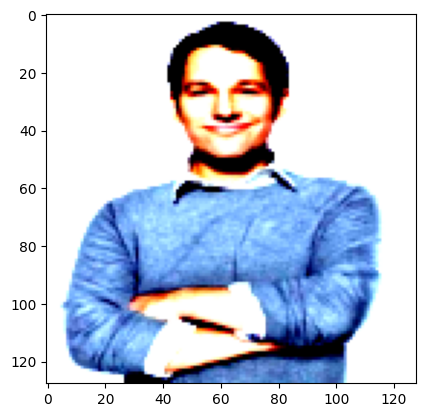

In [64]:
# Load and transform image
#jason_segel = Image.open("/Users/kristinaqualben/Downloads/jason-segel.jpeg")
jason_segel = "/Users/kristinaqualben/Downloads/jason-segel.jpeg"
target = 'paul_rudd' #'paul_rudd' 'puggle' 'jason_segel'
image_path =  f"/Volumes/KCQDrive/projects/images/{target}.jpg"
show_image(image_path, data_module.test_transforms)

In [65]:
from PIL import Image
import torch
pred_image = Image.open(image_path)
pred_image_tensor = data_module.test_transforms(pred_image)
pred_image_tensor_reshaped = pred_image_tensor.unsqueeze(0)

net.eval()
with torch.no_grad():
    pred = net(pred_image_tensor_reshaped).squeeze(0)
pred_cls = pred.softmax(0)
cls_id = pred_cls.argmax().item()


In [70]:
#import pandas as pd
dog_matches = {k: pred_cls.data[v].item() for k, v in data_module.train_set.class_to_idx.items()}
#pred_df = pd.DataFrame(dog_matches.items(), columns = ['dog','probability']).sort_values(by = 'probability', ascending=False).reset_index(drop=True)
#pred_df
dog_matches

{'Abyssinian': 0.014847180806100368,
 'American Bulldog': 0.002890197793021798,
 'American Pit Bull Terrier': 0.0009490554220974445,
 'Basset Hound': 0.0003327408048789948,
 'Beagle': 0.001749881892465055,
 'Bengal': 0.0005416674539446831,
 'Birman': 0.0001606747682671994,
 'Bombay': 0.0001460133644286543,
 'Boxer': 0.00032618679688312113,
 'British Shorthair': 0.007599774282425642,
 'Chihuahua': 0.00448157312348485,
 'Egyptian Mau': 0.006037777755409479,
 'English Cocker Spaniel': 0.0005869721644558012,
 'English Setter': 0.0007050433196127415,
 'German Shorthaired': 0.0035980723332613707,
 'Great Pyrenees': 0.00035853934241458774,
 'Havanese': 0.0007574441260658205,
 'Japanese Chin': 0.000983739853836596,
 'Keeshond': 6.356570520438254e-05,
 'Leonberger': 8.06567695690319e-05,
 'Maine Coon': 0.00013295530516188592,
 'Miniature Pinscher': 0.0005615094560198486,
 'Newfoundland': 0.0003319604438729584,
 'Persian': 0.0007974534528329968,
 'Pomeranian': 0.00021652248688042164,
 'Pug': 0.0

In [ ]:
from torch.utils.tensorboard import SummaryWriter

# Initialize the TensorBoard writer
writer = SummaryWriter(log_dir='logs/experiment1')

# Assuming you have saved your metrics (e.g., in lists)
saved_epochs = list(range(num_epochs))  # Example epoch numbers
saved_losses = [...]  # Your saved loss values
saved_accuracies = [...]  # Your saved accuracy values

# Log metrics
for epoch, (loss, accuracy) in zip(saved_epochs, zip(saved_losses, saved_accuracies)):
    writer.add_scalar('Loss/train', loss, epoch)
    writer.add_scalar('Accuracy/train', accuracy, epoch)

# Close the writer
writer.close()